# Klassifikation Land/Wasser (NDWI)

#### Jugend Forscht - Projekt: "KI-unterstützte Fernerkundung - ein Verfahren hoher Genauigkeit?"
##### Jasper Eggert, Januar 2023

##### Import wichtiger Bibliotheken und Definition der verwendeten Funktionen:

In [2]:
#Import der nötigen Bibliotheken
#SNAPPY-Schnittstelle
import sys
sys.path.append('C:\\Users\\jaspe\\anaconda3\\envs\\Snappy_JuFo\\Lib')
from snappy import ProductIO
from snappy import HashMap
from snappy import GPF

#matplotlib zur Erstellung von Visualisierungen
import matplotlib.pyplot as plot

#NumPy als Darstellungs-Backend für pixelweise Verarbeitung
import numpy as np


#scikit-image zur Manipulation der matplotlib-Darstellungen
import skimage.exposure as exposure

root_folder_path = 'D:/OneDrive - oegym.de/2021_2022/SEM11/'


import time #Time für Messungen der Ausführungszeiten
import random #Random für die zufällige Generierung der Klassifikations-Seeds

onedrive_SNAP_WS = r'D:\OneDrive - oegym.de\2022_2023\Jugend Forscht\SNAP Workspace'

#Definition einer Funktion zum Darstellen der Bilder:
def plot_image(title, bandName, product, cmap, quad_size):
    width = product.getSceneRasterWidth()
    height = product.getSceneRasterHeight()
    band_data = np.zeros(width * height)
    data = product.getBand(bandName).readPixels(0, 0, width, height, band_data)
    band_data.shape = height, width

    val1,val2 = np.percentile(band_data, (2.5,97.5))
    band_data_new = exposure.rescale_intensity(band_data, in_range=(val1,val2))

    w_fig = quad_size
    h_fig = quad_size
    plot.figure(figsize=(w_fig, h_fig))
    plot.imshow(band_data_new, cmap=cmap)
    plot.title(title)

#Definition einer Funktion zur NDWI-Berechnung
def calc_ndwi(product_in, greenSourceBand, nirSourceBand, greenFactor, nirFactor):

    params = HashMap()
    params.put('greenSourceBand', greenSourceBand)
    params.put('nirSourceBand', nirSourceBand)
    params.put('greenFactor', greenFactor)
    params.put('nirFactor', nirFactor)

    return GPF.createProduct('Ndwi2Op', params, product_in)     #Der verwendete NDWI wird in SNAP und Snappy als NDWI2 bezeichnet

#Funktion zum Resampling der Satellitenbilder
def S2Resampling (product_in, resolution):
    params = HashMap()
    params.put('resolution', resolution)
    params.put('upsampling', 'Bilinear')
    params.put('downsampling', 'Mean')
    params.put('flagDownsampling', 'First')
    params.put('resampleOnPyramidLevels', True)

    return GPF.createProduct('S2Resampling', params, product_in)

def kmeans_class(product_in, numIterations, numClusters):
    params = HashMap()
    params.put('clusterCount', numClusters)
    params.put('iterationCount', numIterations)
    params.put('randomSeed', random.randint(1,10000))

    return GPF.createProduct('KMeansClusterAnalysis', params, product_in)

##### Einlesen der Quelldaten (L1C):

In [2]:
%%time
full_L1C = ProductIO.readProduct (onedrive_SNAP_WS + r'\Satellitendaten\Source\S2A_MSIL1C_20220812T103031_N0400_R108_T32UME_20220812T155113.zip') # full: Präfix für vollständiges Quellprodukt mit allen Bändern

Wall time: 10.8 s


##### Zwischenschritt: Rayleigh-Korrektur & Resampling in SNAP Desktop
$p=1013,25 hPa$ <br/>
$Ozone=300.0 du$ <br/>
Bänder: B8, B4, B3, B2 <br/>
<br/>
Einlesen des aufbereiteten Produkts::

In [5]:
%%time
full_L1C_Res10 = ProductIO.readProduct (onedrive_SNAP_WS + r'\Satellitendaten\Full_L1C_Res10.dim') # full: Präfix für vollständiges Quellprodukt mit allen Bändern

Wall time: 1.61 s


Berechnung des NDWI des L1C-Produkts mittels vorher definierter Funktion und Speichern dieses Produkts:

In [6]:
L1C_NDWI = calc_ndwi(full_L1C_Res10, 'B3', 'B8', '1.0', '1.0')
ProductIO.writeProduct(L1C_NDWI, onedrive_SNAP_WS + r'\Satellitendaten\NDWI\L1C_NDWI.tif', 'GeoTIFF')

Klassifikationen mit K-Means-Operator des SNAP-GPF (Graph Processing Framework):

In [10]:
%%timeit
L1C_NDWI_kmeans_2_200 = kmeans_class(L1C_NDWI, 200, 2)

698 µs ± 142 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
%%timeit
L1C_NDWI_kmeans_2_300 = kmeans_class(L1C_NDWI, 300, 2)

725 µs ± 115 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%%timeit
L1C_NDWI_kmeans_3_200 = kmeans_class(L1C_NDWI, 200, 3)

766 µs ± 213 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit
L1C_NDWI_kmeans_3_300 = kmeans_class(L1C_NDWI, 300, 3)

687 µs ± 180 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


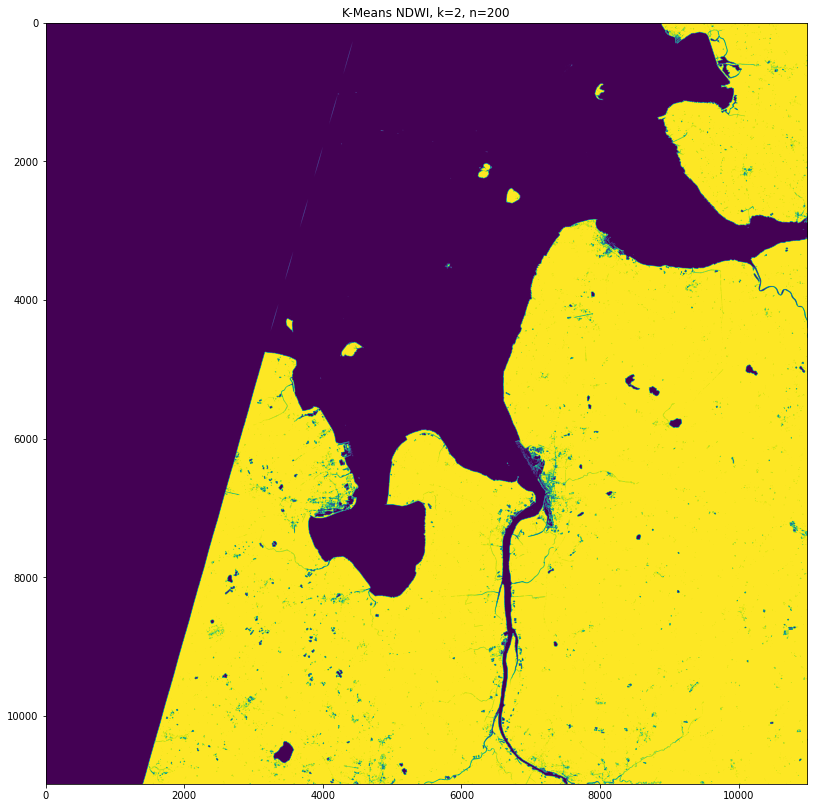

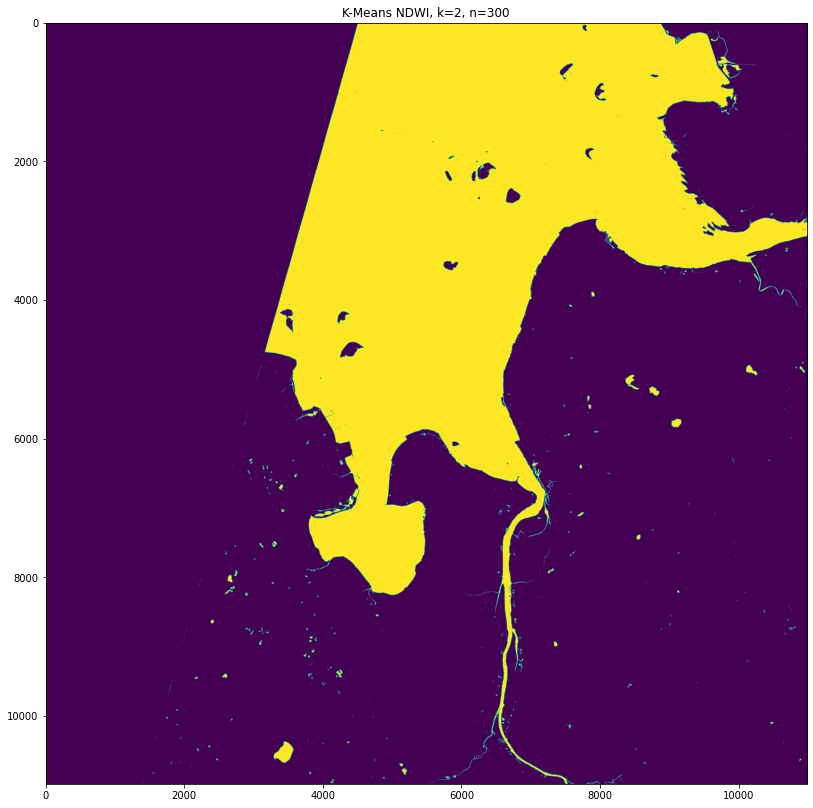

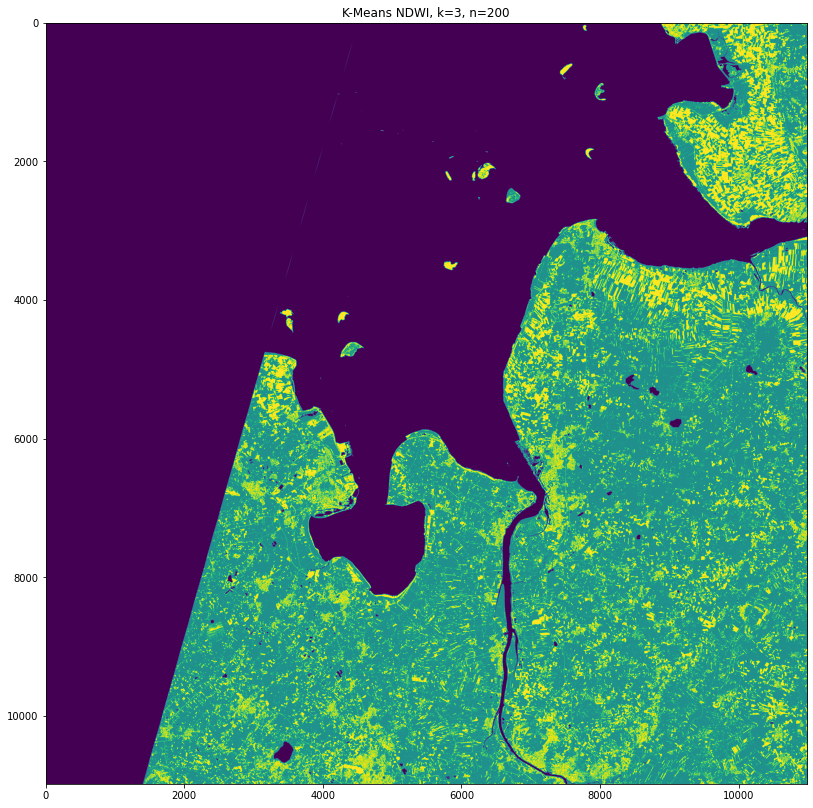

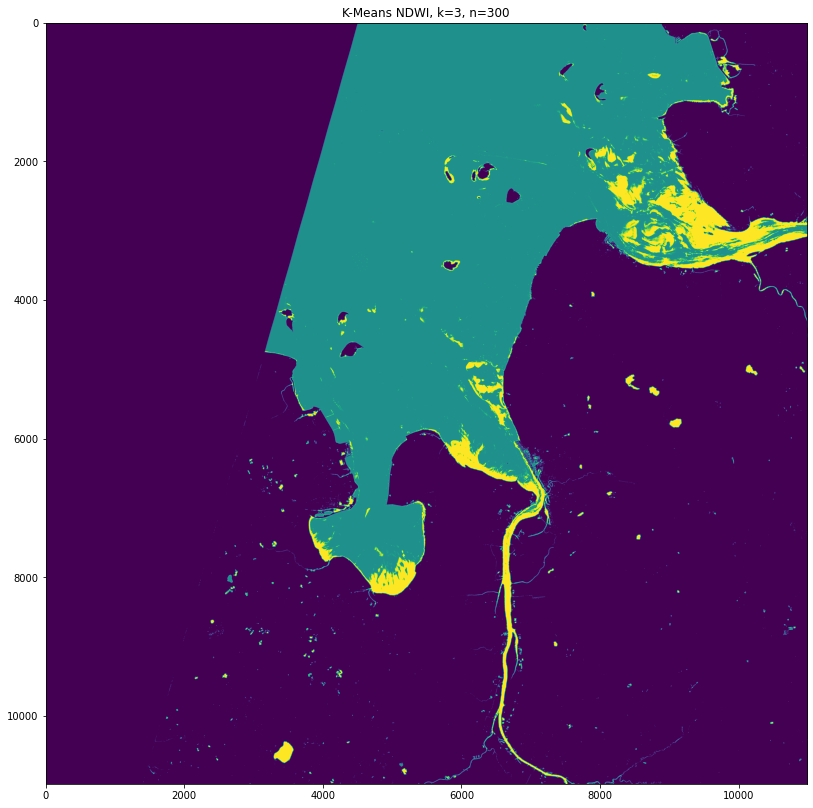

In [5]:
L1C_NDWI_kmeans_2_200 = kmeans_class(L1C_NDWI, 200, 2)
L1C_NDWI_kmeans_2_300 = kmeans_class(L1C_NDWI, 300, 2)
L1C_NDWI_kmeans_3_200 = kmeans_class(L1C_NDWI, 200, 3)
L1C_NDWI_kmeans_3_300 = kmeans_class(L1C_NDWI, 300, 3)

plot_image('K-Means NDWI, k=2, n=200', 'class_indices', L1C_NDWI_kmeans_2_200, plot.cm.viridis, 14)
plot_image('K-Means NDWI, k=2, n=300', 'class_indices', L1C_NDWI_kmeans_2_300, plot.cm.viridis, 14)
plot_image('K-Means NDWI, k=3, n=200', 'class_indices', L1C_NDWI_kmeans_3_200, plot.cm.viridis, 14)
plot_image('K-Means NDWI, k=3, n=300', 'class_indices', L1C_NDWI_kmeans_3_300, plot.cm.viridis, 14)

ProductIO.writeProduct(L1C_NDWI_kmeans_2_200, onedrive_SNAP_WS + r'\Satellitendaten\NDWI\L1C_NDWI_KMeans_2_200', 'GeoTIFF')
ProductIO.writeProduct(L1C_NDWI_kmeans_2_300, onedrive_SNAP_WS + r'\Satellitendaten\NDWI\L1C_NDWI_KMeans_2_300', 'GeoTIFF')
ProductIO.writeProduct(L1C_NDWI_kmeans_3_200, onedrive_SNAP_WS + r'\Satellitendaten\NDWI\L1C_NDWI_KMeans_3_200', 'GeoTIFF')
ProductIO.writeProduct(L1C_NDWI_kmeans_3_300, onedrive_SNAP_WS + r'\Satellitendaten\NDWI\L1C_NDWI_KMeans_3_300', 'GeoTIFF')

Speichern des NDWI-Produkts als JPG zur $k$-means-Klassifikation mit openCV:

In [30]:
# k-means mit openCV (nach https://www.geeksforgeeks.org/image-segmentation-using-k-means-clustering/)
import cv2
import os

print(os.path.exists(r'D:\OneDrive - oegym.de\2022_2023\Jugend Forscht\SNAP Workspace\Satellitendaten\L1C_NDWI.tif'))
daten = cv2.imread(r'D:\OneDrive - oegym.de\2022_2023\Jugend Forscht\SNAP Workspace\Satellitendaten\L1C_NDWI.tif')
print(f'dtype: {daten.dtype}, shape: {daten.shape}, min: {np.min(daten)}, max: {np.max(daten)}')

daten = cv2.cvtColor(daten, cv2.COLOR_GRAY2RGB)

pixel_vals = daten.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)

criteria = (cv2.TERM_CRITERIA_MAX_ITER, 100)



#maximale Clusteranzahl k=6
for k in range(2, 6):
    retvals, labels, centres, epsilon = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    error = []
    error[k] = epsilon

    centers = np.uint8(centres)
    classedData = centers[labels.flatten()]

    classedImage = classedData.reshape((daten.shape))
    plot.imshow(classedImage)

print(error)


True


AttributeError: 'NoneType' object has no attribute 'dtype'